# Delineating Watershed Boundary using Pysheds
### Includes figures for each step of the process

In [1]:
#use environment planet_env(Pythin 3.11.7)
#!pip install pysheds

In [1]:
import pysheds

In [2]:
import numpy as np
import pandas as pd
from pysheds.grid import Grid
import geopandas as gpd
from shapely import geometry, ops
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
from shapely.geometry import LineString
import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl')
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

In [3]:
demdir = '/home/etboud/projects/Data/output/'
id = 'mosaic_output'
dem_fn = os.path.join(demdir, id+'.tif')

# Instatiate a grid from a raster
grid = Grid.from_raster(dem_fn, data_name='dem')
dem = grid.read_raster(dem_fn, data_name='dem')


# /home/etboud/projects/Data/output/mosaic_output.tif

In [ ]:
# elevation map (don't need to run everytime)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

## Fill in pits on DEM
pixels with values lower than surrounding values may be problematic. Here we give those pixels the same values as their surrounding ones. Now there shouldn't be accumulation issues from the pits.

In [4]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

## Estimating Flow Direction
Here we estimate the direction map, defining 8 possible directions that one cell can follow. Each number is a different direction.

In [6]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

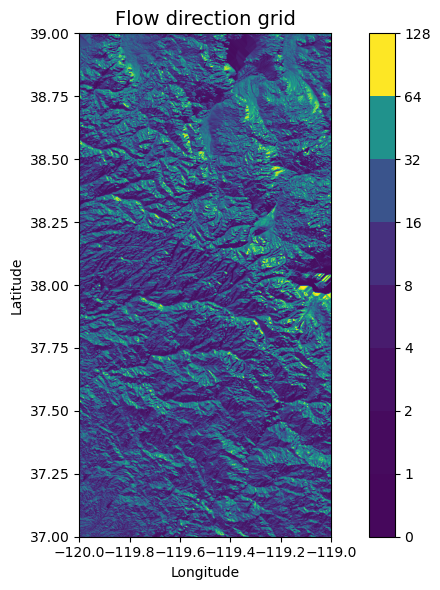

In [12]:
#flow direction plot do not run everytime
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries, values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

## Estimating Flow Accumulation
This part estimates total contributing area for each cell. Sums the number of cells that contribute to each cell.

In [7]:
#Calculate flow accumulation
#--------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

In [8]:
q01_x,q01_y = -119.26139, 37.77778 #lyell Fork Below Maclure
q02_x,q02_y = -119.3311, 37.869 #Lyell Fk. Tuolumne R. at Twin Bridges
q03_x,q03_y = -119.338, 37.877 #Dana Fk. Tuolumne R. at Bug Camp
q04_x,q04_y = -119.35475, 37.87629 # Tuolumne R. at Highway 120
q05_x,q05_y = -119.381056, 37.883357 # Delaney Cr. At Tuolumne Meadows
q06_x,q06_y = -119.382, 37.89489 # Budd Cr. At Tuolumne Meadows
point_x, point_y = -119.7879546, 37.9476989 # outlet

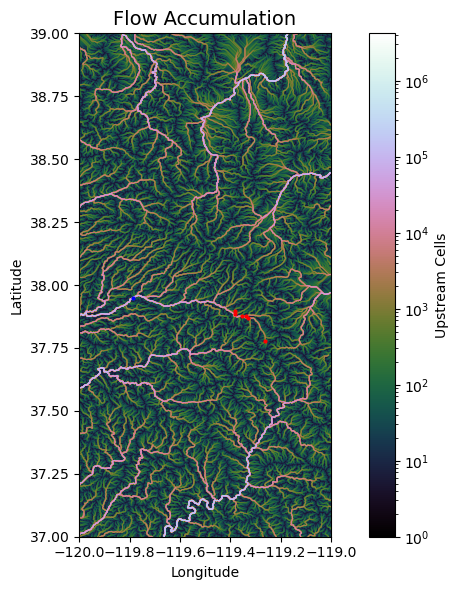

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
point_x, point_y = -119.7879546, 37.9476989
plt.scatter(point_x, point_y, color='blue', s=4, label='Your Point', zorder=2)
plt.scatter(q01_x, q01_y, color='red', s = 4, label='Q01', zorder=2)
plt.scatter(q02_x, q02_y, color='red', s= 4, label='Q02', zorder=2)
plt.scatter(q03_x, q03_y, color='red', s=4, label='Q03', zorder=2)
plt.scatter(q04_x, q04_y, color='red', s=4, label='Q04', zorder=2)
plt.scatter(q05_x, q05_y, color='red', s=4, label='Q05', zorder=2)
plt.scatter(q06_x, q06_y, color='red', s=4, label='Q06', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

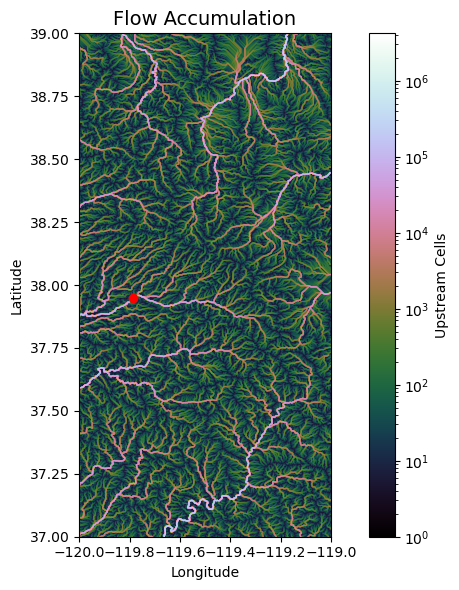

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')

point_x, point_y = -119.7879546, 37.9476989
plt.scatter(point_x, point_y, color='red', label='Your Point', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

## Catchment Delineation
First select the pour point (most downstream of the catchment).You can use QGIS to determine these coordinates by using the Identify Features Icon and clock on the downstream pixel.

Points are snapped to the nearest cell in a binary mask. The 1000 specifies only cells with accumulated flow values greater than 1000 will be considered for snapping

In [21]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -119.7879546, 37.9476989

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 20000, (q03_x, q03_y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

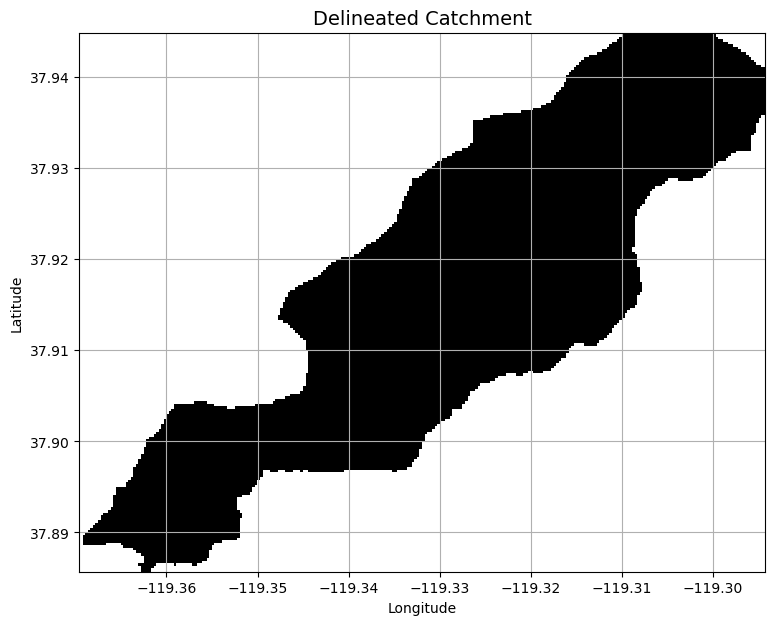

In [22]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.scatter(q03_x, q03_y, color='red', label='Your Point', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

## Extract River Network

If number of flow accumulation is greater than threshold the pixels will be characterized as a river. The lower the number, the denser the river network.

In [43]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 15000, dirmap=dirmap)

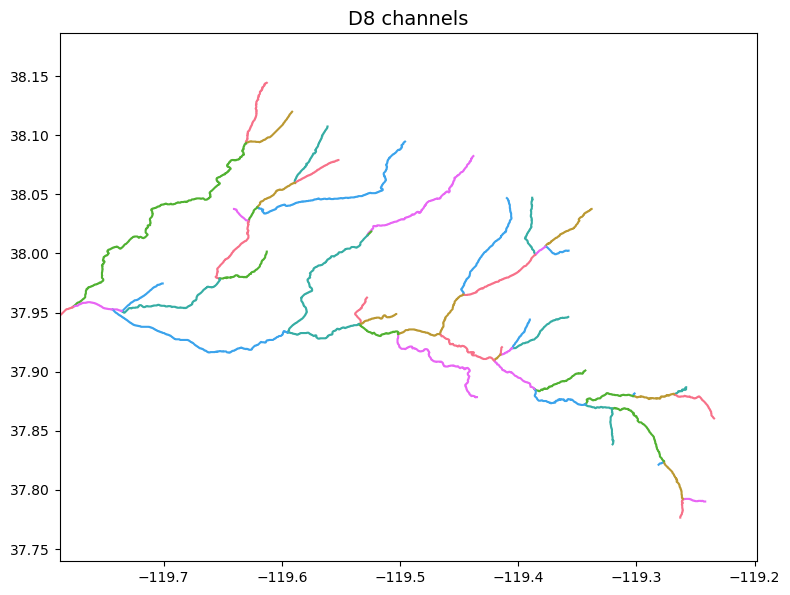

In [44]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(9,7))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

In [45]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                               xytype='coordinate')

In [22]:
# from matplotlib.patches import FancyArrowPatch
# from matplotlib.offsetbox import AnnotationBbox
# from matplotlib.patches import FancyArrowPatch, ArrowStyle
import contextily as ctx

In [23]:
dist.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

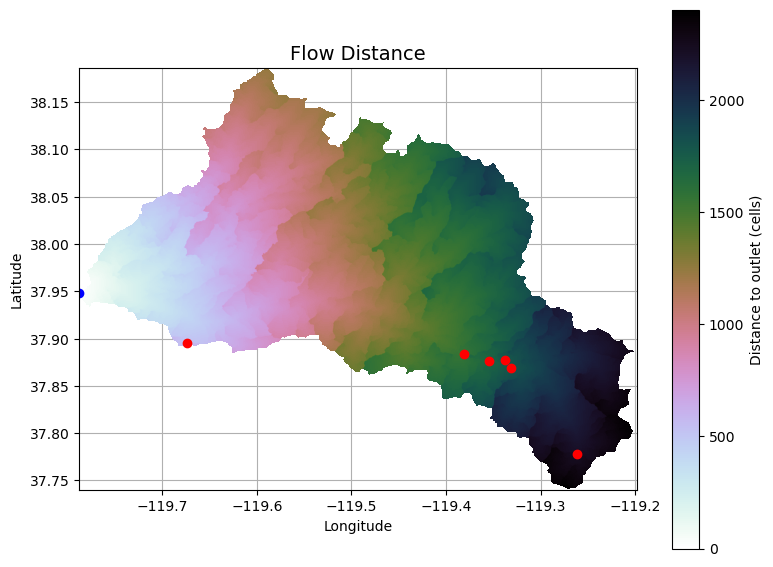

In [46]:
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.scatter(point_x, point_y, color='blue', label='Your Point', zorder=2)
plt.scatter(q01_x, q01_y, color='red', label='Your Point', zorder=2)
plt.scatter(q02_x, q02_y, color='red', label='Your Point', zorder=2)
plt.scatter(q03_x, q03_y, color='red', label='Your Point', zorder=2)
plt.scatter(q04_x, q04_y, color='red', label='Your Point', zorder=2)
plt.scatter(q05_x, q05_y, color='red', label='Your Point', zorder=2)
plt.scatter(q06_x, q06_y, color='red', label='Your Point', zorder=2)
#plt.xlim(grid.extent[:2])
#ctx.add_basemap(ax=ax,crs=dist.crs,source=ctx.providers.Esri.WorldImagery,attribution='')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# style = ArrowStyle('Fancy', head_length=1, head_width=1.5, tail_width=0.5)
# arrow = FancyArrowPatch((0, 0), (1, 1), mutation_scale=25, arrowstyle=style, color='k') 
# north_arrow = FancyArrowPatch((0.95, 0.95), (0.95, 0.85),mutation_scale=25, arrowstyle=style, color='k')
# ax.add_patch(north_arrow)
# ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.96), ha='center', va='center')


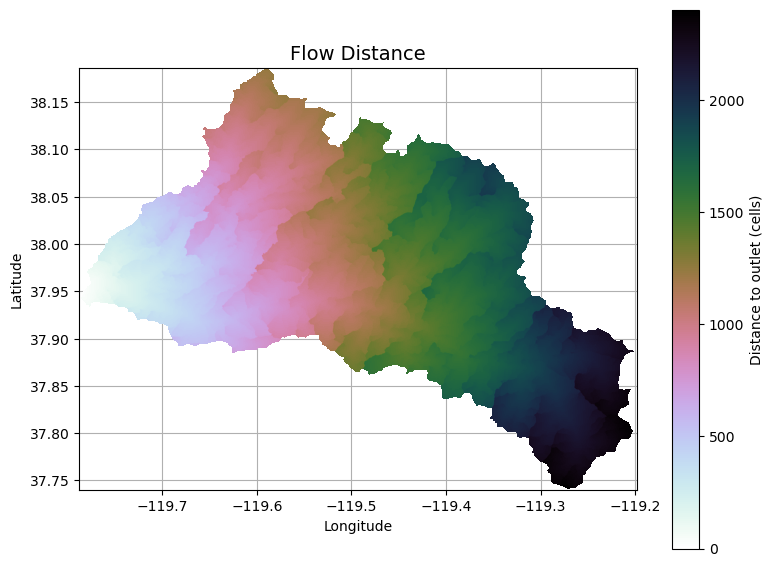

In [25]:
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.xlim(grid.extent[:2])
#ctx.add_basemap(ax=ax,crs=dist.crs,source=ctx.providers.Esri.WorldImagery,attribution='')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

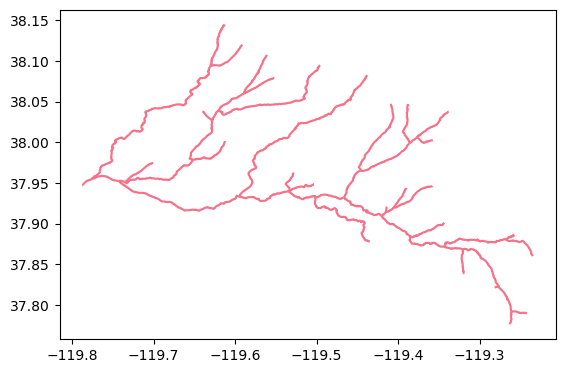

In [48]:
# saving rivers as shapefile
line_strings = []

for branch in branches['features']:
    line_coords = branch['geometry']['coordinates']
    line = LineString(line_coords)
    line_strings.append(line)

gdf = gpd.GeoDataFrame(geometry=line_strings)
gdf.plot()

gdf.to_file('tuo_network.shp')

In [1]:
import geopandas as gpd

shapefile = gpd.read_file("/home/etboud/projects/Data/shp_out/tuo_network.shp")


    FID                                           geometry
0     0  LINESTRING (-119.61264 38.14431, -119.61292 38...
1     1  LINESTRING (-119.59125 38.11986, -119.59153 38...
2     2  LINESTRING (-119.63014 38.09319, -119.63042 38...
3     3  LINESTRING (-119.56125 38.10736, -119.56125 38...
4     4  LINESTRING (-119.49569 38.09458, -119.49597 38...
5     5  LINESTRING (-119.43792 38.08236, -119.43819 38...
6     6  LINESTRING (-119.55208 38.07903, -119.55236 38...
7     7  LINESTRING (-119.58875 38.05958, -119.58903 38...
8     8  LINESTRING (-119.62069 38.03903, -119.62097 38...
9     9  LINESTRING (-119.38819 38.04708, -119.38819 38...
10   10  LINESTRING (-119.40958 38.04681, -119.40931 38...
11   11  LINESTRING (-119.64042 38.03764, -119.64014 38...
12   12  LINESTRING (-119.62792 38.02708, -119.62792 38...
13   13  LINESTRING (-119.33792 38.03764, -119.33819 38...
14   14  LINESTRING (-119.52431 38.01847, -119.52458 38...
15   15  LINESTRING (-119.52736 38.01542, -119.52764 38.

citation

@misc{bartos_2020,
    title  = {pysheds: simple and fast watershed delineation in python},
    author = {Bartos, Matt},
    url    = {https://github.com/mdbartos/pysheds},
    year   = {2020},
    doi    = {10.5281/zenodo.3822494}
}